## Simulating Data

This is notebook is for producing simulated Quasi Periodic Oscillations and fitting GPs on them

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will produce 1000 simulated light curves of all three of these parameters and they will be 1s long with 256 time bins. The mean model will be a skew gaussian.

In [2]:
# Loading Dependencies

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [3]:
from tinygp import kernels

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

In [6]:
# Making kernels for the lightcurves

class QPO_kernel(tinygp.kernels.Kernel):
    """
    An inheritance class for tinygp.kernels.kernels which makes a
    kernel for a QPO structure.
    This QPO covariance function is based on the Lorentzian function with
    qpo representation and an added red noise.
    Parameters
    ----------
    arn  : float
        The amplitude of the Red noise
    crn  : float
        The decay value for the red noise
    aqpo : float
        The amplitude of the lorentzian
    cqpo : float
        The decay value for the qpo frequency
    freq : float
        The modelled frequency for the QPO
    """

    def __init__(self, arn, crn, aqpo, cqpo, freq):
        self.arn = jnp.atleast_1d(arn)
        self.crn = jnp.atleast_1d(crn)
        self.aqpo = jnp.atleast_1d(aqpo)
        self.cqpo = jnp.atleast_1d(cqpo)
        self.freq = jnp.atleast_1d(freq)

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.aqpo
            * jnp.prod(jnp.exp(-self.cqpo * tau) * jnp.cos(2 * jnp.pi * self.freq * tau), axis=-1)
            +
            self.arn
            * jnp.prod(jnp.exp(-self.crn * tau), axis=-1)
        )

# As all models have same so put here itself
A = 3
t0 = 0.5
sig = 0.2
def skew_gaussian(t):
    return A * jnp.exp(-((t - t0)**2)/(2*(sig**2)))

def skew_gaussian2(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

def build_gp(kernel_params, mean_params, t):
    kernel = QPO_kernel(
        jnp.exp(kernel_params["arn"]),
        jnp.exp(kernel_params["crn"]),
        jnp.exp(kernel_params["aqpo"]),
        jnp.exp(kernel_params["cqpo"]),
        jnp.exp(kernel_params["freq"]),
    )
    mean = functools.partial(skew_gaussian2, mean_params = mean_params)
    return tinygp.GaussianProcess(
        kernel, t, mean=mean
    )


In [5]:
# Making the rn kernel

rnparams = {
    "arn": jnp.exp(1.0),
    "crn": jnp.exp(1.0),
    "aqpo": 0.0,
    "cqpo": 0.0,
    "freq": 0.0,
}

rnkernel = QPO_kernel(rnparams["arn"], rnparams["crn"], 
                      rnparams["aqpo"], rnparams["cqpo"], rnparams["freq"])

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 1, 50)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.legend()
    plt.ylabel("k(dx)")

In [7]:
lqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

lqpokernel = QPO_kernel(lqpoparams["arn"], lqpoparams["crn"],
                       lqpoparams["aqpo"], lqpoparams["cqpo"], lqpoparams["freq"])


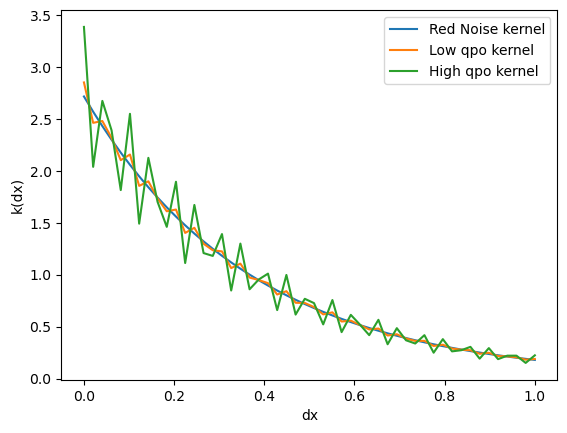

In [8]:
hqpoparams = {
    "arn" : jnp.exp(1.0),
    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),
    "cqpo": jnp.exp(1),
    "freq": 20,
}

hqpokernel = QPO_kernel(hqpoparams["arn"], hqpoparams["crn"],
                       hqpoparams["aqpo"], hqpoparams["cqpo"], hqpoparams["freq"])

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

Text(0, 0.5, 'M(x)')

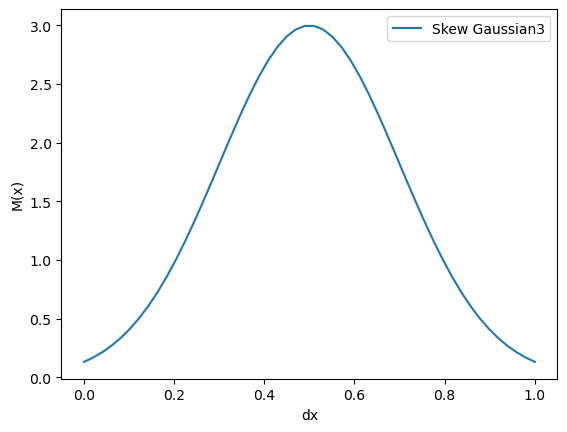

In [9]:
# Plotting the mean function:-

mean_params = {
    "A" : 3,
    "t0" : 0.5,
    "sig" : 0.2,
}

skew_gaussian3 = functools.partial(skew_gaussian2, mean_params = mean_params)

dx = np.linspace(0, 1, 50)
plt.plot(dx, skew_gaussian3(dx), label = "Skew Gaussian3")
# plt.plot(dx, skew_gaussian(dx), label = "Skew Gaussian")
plt.xlabel("dx")
plt.legend()
plt.ylabel("M(x)")

Text(0.5, 0, 'x')

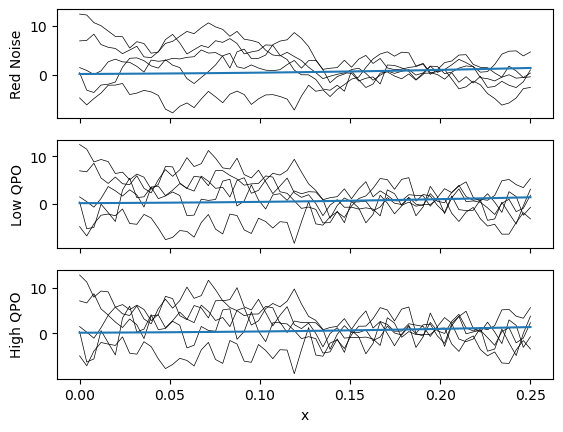

In [10]:
# Making the simulated data

# times = np.linspace(0, 1, 256)
# Shortened the duration of time to 1/4th of the original, 256/4 = 64
times = np.linspace(0, 1/4, 64)
rngp = build_gp(rnparams, mean_params, times)
lqpop = build_gp(lqpoparams, mean_params, times)
hqpop = build_gp(hqpoparams, mean_params, times)

rngp_sample = rngp.sample(jax.random.PRNGKey(4), shape=(5,))
lqpogp_sample = lqpop.sample(jax.random.PRNGKey(4), shape=(5,))
hqpogp_sample = hqpop.sample(jax.random.PRNGKey(4), shape=(5,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(times, rngp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(times, lqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("Low QPO")

ax = axes[2]
ax.plot(times, hqpogp_sample.T, color="k", lw=0.5)
ax.plot(times, jax.vmap(skew_gaussian)(times), label="mean")
ax.set_ylabel("High QPO")

ax.set_xlabel("x")

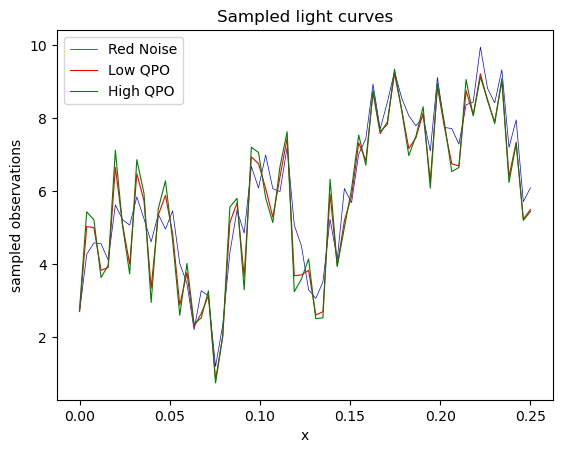

In [10]:
rngp_sample2   =  rngp.sample(jax.random.PRNGKey(5), shape=(1,))
lqpogp_sample2 = lqpop.sample(jax.random.PRNGKey(5), shape=(1,))
hqpogp_sample2 = hqpop.sample(jax.random.PRNGKey(5), shape=(1,))

plt.plot(times, rngp_sample2.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(times, lqpogp_sample2.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(times, hqpogp_sample2.T, lw=0.8, color = "g", label = "High QPO")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

# Why so similar, what about -ve elements?

In [11]:
# Calculating evidences using jaxns
# Loading dependencies

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions


In [13]:
from jaxns import Prior, Model

# Defining the RN prior

def RNprior_model():
    # Is it log Normal or Uniform?
    # Feeding the values manually, should be put for lightcurve to lightcurve
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn')
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    # aqpo = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='aqpo')
    # cqpo = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='cqpo')
    # freq = yield Prior(tfpd.LogNormal(jnp.log(1.), 1.), name='freq')

    A = yield Prior(tfpd.Uniform(0.1*20, 2*20), name='A')
    t0 = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='t0')
    sig = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='sig')

    return arn, crn, A, t0, sig # aqpo, cqpo, freq

# Defining the QPO prior

def QPOprior_model():
    arn = yield Prior(tfpd.Uniform(0.0, 20.0), name='arn')
    crn = yield Prior(tfpd.Uniform(1., 256/2), name='crn')
    # Should be Based on the lightcurve
    aqpo = yield Prior(tfpd.Uniform(0.0, 20.0), name='aqpo')
    # Should be dependent on the freq below (max value less than freq), Hense adjusting for that
    cqpo = yield Prior(tfpd.Uniform(0.1*1, 256/8), name='cqpo')
    freq = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='freq')

    A = yield Prior(tfpd.Uniform(0.1*20, 2*20), name='A')
    t0 = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='t0')
    sig = yield Prior(tfpd.Uniform(jnp.log(1.), 1.), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig


In [14]:
hqpogp_sample3 = hqpop.sample(jax.random.PRNGKey(4))
print(type(hqpogp_sample3))
print(hqpogp_sample3.shape)
# Its a jaxlib array of size (1,256)

# Printing its log_likelihood, the shape has to be this

print(hqpop.log_probability(hqpogp_sample3))

<class 'jaxlib.xla_extension.ArrayImpl'>
(64,)
-132.91138411391898


In [15]:
# Will do it for a High QPO first

def RNlog_likelihood(arn, crn, A, t0, sig):
    rnlikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": 0.0,
        "cqpo": 0.0,
        "freq": 0.0,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(rnlikelihood_params, mean_params, times)
    # Condition on the data, hense we will have to make a separate function for each data point
    return gp.log_probability(hqpogp_sample3)

def QPOlog_likelihood(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
    rnlikelihood_params = {
        "arn": arn,
        "crn": crn,
        "aqpo": aqpo,
        "cqpo": cqpo,
        "freq": freq,
        }
    # Make a mean model, make the gp, and conditon on time and sample
    mean_params = {
        "A": A,
        "t0": t0,
        "sig": sig,
        }
    # Make the GP
    gp = build_gp(rnlikelihood_params, mean_params, times)
    # Condition on the data
    return gp.log_probability(hqpogp_sample3)

In [16]:
RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood)
RNmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-05-25 16:13:20,653]: Sanity check...
INFO[2023-05-25 16:13:21,089]: Sanity check passed


In [16]:
RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)

RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)

In [18]:
print(RNresults.log_Z_mean) # -158, excellent

-158.34650853355245


In [19]:
from jaxns import analytic_log_evidence
# Took only 3m which is faster than Exact Nested Sampling
print(analytic_log_evidence(RNmodel, S = 10))

-166.9487566155813


In [17]:
QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood)
QPOmodel.sanity_check(random.PRNGKey(10), S = 100)

INFO[2023-05-25 16:13:28,544]: Sanity check...
INFO[2023-05-25 16:13:28,803]: Sanity check passed


In [23]:
QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)

QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)

# Took 9 minutes in intital run

In [24]:
print(QPOresults.log_Z_mean) # Just a small difference bw rn and qpo_rn, but still good

-156.16567100724762


In [18]:
# Will produce 10 samples and get the bayes factor for them
BF = np.zeros(10)

for i in range(10):
    print(f"Sample {i}")
    hqpogp_sample = hqpop.sample(jax.random.PRNGKey(i*i))
    print(hqpop.log_probability(hqpogp_sample))
    
    def RNlog_likelihood2(arn, crn, A, t0, sig):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": 0.0,
            "cqpo": 0.0,
            "freq": 0.0,
            }
        # Make a mean model, make the gp, and conditon on time and sample
        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
            }
        # Make the GP
        gp = build_gp(rnlikelihood_params, mean_params, times)
        # Condition on the data, hense we will have to make a separate function for each data point
        return gp.log_probability(hqpogp_sample)

    def QPOlog_likelihood2(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": aqpo,
            "cqpo": cqpo,
            "freq": freq,
            }
        # Make a mean model, make the gp, and conditon on time and sample
        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
            }
        # Make the GP
        gp = build_gp(rnlikelihood_params, mean_params, times)
        # Condition on the data
        return gp.log_probability(hqpogp_sample)
    
    RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood2)
    RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500,
                             max_samples= 1e4)
    RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)
    print(RNresults.log_Z_mean)

    QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood2)
    QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500,
                             max_samples= 1e4)
    QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)
    print(QPOresults.log_Z_mean)

    BF[i] = QPOresults.log_Z_mean - RNresults.log_Z_mean
    
        

Sample 0
-130.14597187033655
-166.39454866882934
-160.73302423205328
Sample 1
-131.89327732470716
-151.52616949248792
-152.27157140061541
Sample 2
-132.91138411391898
-158.34650853355245
-156.16567100724762
Sample 3
-124.99860206459928
-144.91863731341016
-146.41726986140944
Sample 4
-130.06821348091978
-143.90478632398026
-142.46895758107172
Sample 5
-129.55050933188102
-163.35016604560968
-161.16103273278435
Sample 6
-126.32724912254061
-152.88667775699568
-151.52161736183533
Sample 7
-135.51959947051103
-178.10409530706247
-170.23493595430568
Sample 8
-134.60254994367344
-144.52507410630966


In [ ]:
BF = np.exp(BF)
plt.hist(BF, bins = 5)